<a href="https://colab.research.google.com/github/somewhereovertherainbo/COMPUTERVISION/blob/main/LOADING_CUSTOM_DATA_AND_REDUCING_OVERFITTING_USING_DATA_AUGMENTATION_ON_LANDSCAPE_IMAGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
torch.__version__

'2.1.0+cu121'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
import pathlib
import zipfile
from pathlib import Path
import requests

In [5]:
data_path = Path('data/')

if data_path.is_dir():
  print(f'{data_path} already exists')
else:
  data_path.mkdir(parents=True, exist_ok=True)

  with open(data_path/'landscape_images.zip', 'wb') as f:
    request = requests.get('https://github.com/somewhereovertherainbo/COMPUTERVISION/raw/main/landscape%20data.zip')
    f.write(request.content)

  with zipfile.ZipFile(data_path/'landscape_images.zip','r') as zip_ref:
    zip_ref.extractall(data_path)

In [6]:
import os

In [7]:
for dirpath, dirnames, filenames in os.walk(data_path/'landscape data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'data/landscape data'.
There are 5 directories and 0 images in 'data/landscape data/test'.
There are 0 directories and 100 images in 'data/landscape data/test/Mountain'.
There are 0 directories and 100 images in 'data/landscape data/test/Coast'.
There are 0 directories and 100 images in 'data/landscape data/test/Glacier'.
There are 0 directories and 100 images in 'data/landscape data/test/Desert'.
There are 0 directories and 100 images in 'data/landscape data/test/Forest'.
There are 5 directories and 0 images in 'data/landscape data/train'.
There are 0 directories and 199 images in 'data/landscape data/train/Mountain'.
There are 0 directories and 200 images in 'data/landscape data/train/Coast'.
There are 0 directories and 200 images in 'data/landscape data/train/Glacier'.
There are 0 directories and 200 images in 'data/landscape data/train/Desert'.
There are 0 directories and 200 images in 'data/landscape data/train/Forest'.


In [8]:
train_dir = data_path/'landscape data'/'train'
test_dir = data_path/'landscape data'/'test'

Text(0.5, 1.0, 'Mountain')

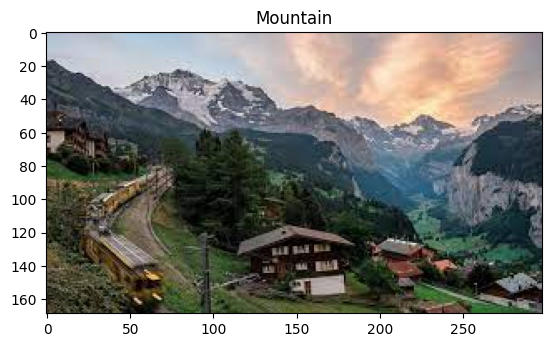

In [9]:
import random
import matplotlib.pyplot as plt
from PIL import Image

image_paths = train_dir.glob('*/*.jpeg')
image_path_list = list(image_paths)
# 2. Get random image path
random_image_path = random.choice(image_path_list)
# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# 4. Open image
img = Image.open(random_image_path)

plt.imshow(img)
plt.title(image_class)

In [10]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [11]:
data_transform = v2.Compose([
    # Resize the images to 64x64
    v2.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    v2.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    v2.PILToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

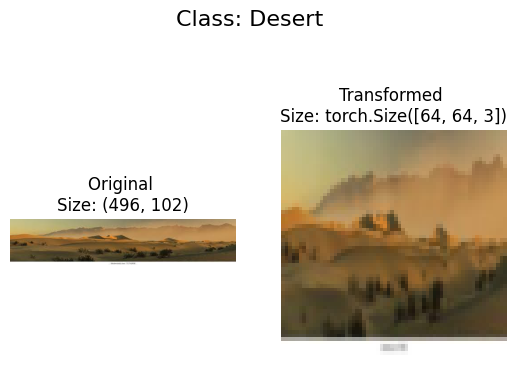

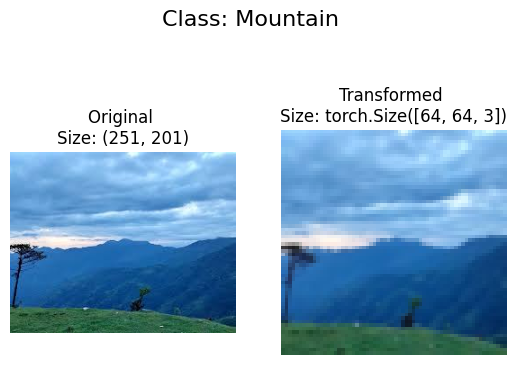

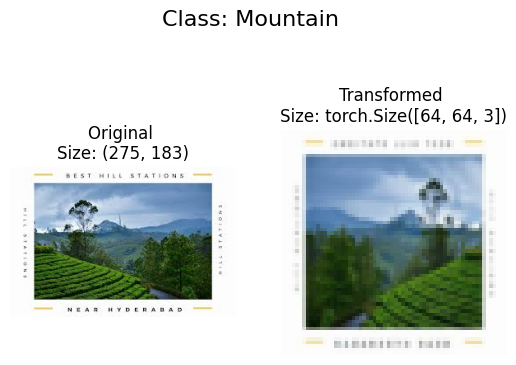

In [12]:
def show_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
      with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        # Transform and plot image
        # Note: permute() will change shape of image to suit matplotlib
        # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

show_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)




In [13]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 999
    Root location: data/landscape data/train
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 PILToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 500
    Root location: data/landscape data/test
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                 RandomHorizontalFlip(p=0.5)
                 PILToTensor()
           )


In [14]:
class_names = train_data.classes
class_names

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

In [15]:
len(train_data), len(test_data)

(999, 500)

In [16]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c10cc7e70a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c10cc7e6bf0>)

In [17]:
train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    v2.PILToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor()
])

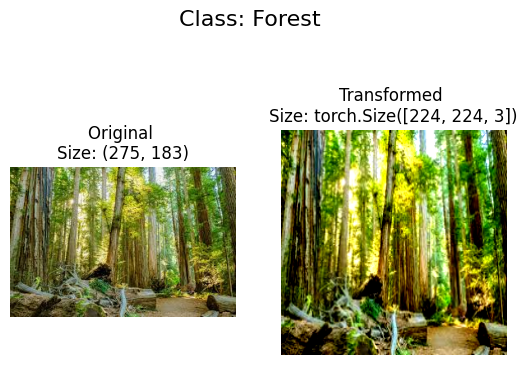

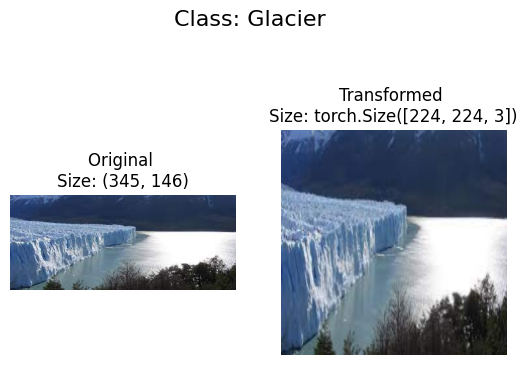

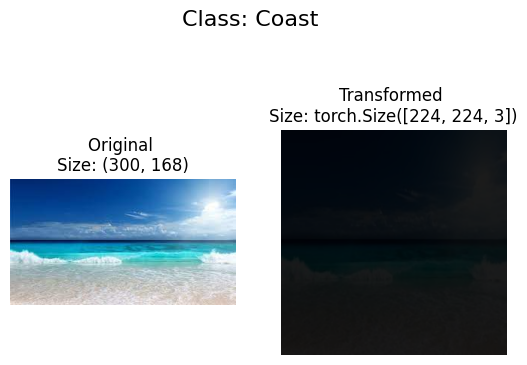

In [18]:
# Get all image paths
# image_path_list = list(image_paths.glob("*/*/*.jpg"))

# Plot random images
show_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## Training model without augmentation transforms

In [19]:
from torchvision.transforms import v2
simple_transform = v2.Compose([
    v2.Resize(size = (64,64)),
    v2.PILToTensor(),
    v2.ToDtype(dtype = torch.float, scale = True)
])

In [20]:
# GETTING DATA INTO A DATASET AND A DATALOADER
train_data_simple = torchvision.datasets.ImageFolder(root = train_dir,
                                                     transform = simple_transform)
test_data_simple = torchvision.datasets.ImageFolder(root = test_dir,
                                                    transform = simple_transform)

BATCH_SIZE = 32
num_workers = os.cpu_count()

train_dataloader_simple = torch.utils.data.DataLoader(dataset = train_data_simple,
                                                      batch_size = BATCH_SIZE,
                                                      num_workers = num_workers,
                                                      shuffle = True)
test_dataloader_simple = torch.utils.data.DataLoader(dataset = test_data_simple,
                                                     batch_size = BATCH_SIZE,
                                                     num_workers = num_workers,
                                                     shuffle = True)

In [21]:
from torch import nn

In [22]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=5, bias=True)
  )
)

In [24]:
!pip install torchinfo

In [25]:
from torchinfo import summary

model = model_0
summary(model, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [26]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [27]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [28]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [29]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6022 | train_acc: 0.2369 | test_loss: 1.5437 | test_acc: 0.3262
Epoch: 2 | train_loss: 1.3378 | train_acc: 0.5077 | test_loss: 1.1312 | test_acc: 0.5574
Epoch: 3 | train_loss: 0.9418 | train_acc: 0.6299 | test_loss: 0.9851 | test_acc: 0.6207
Epoch: 4 | train_loss: 0.8798 | train_acc: 0.6557 | test_loss: 0.9158 | test_acc: 0.6578
Epoch: 5 | train_loss: 0.8219 | train_acc: 0.6835 | test_loss: 0.9440 | test_acc: 0.6441
Epoch: 6 | train_loss: 0.7883 | train_acc: 0.6971 | test_loss: 0.9022 | test_acc: 0.6660
Epoch: 7 | train_loss: 0.7516 | train_acc: 0.7207 | test_loss: 0.8827 | test_acc: 0.6473
Epoch: 8 | train_loss: 0.7347 | train_acc: 0.7328 | test_loss: 0.8840 | test_acc: 0.6578
Epoch: 9 | train_loss: 0.7375 | train_acc: 0.7112 | test_loss: 0.9172 | test_acc: 0.6562
Epoch: 10 | train_loss: 0.7383 | train_acc: 0.7118 | test_loss: 0.8461 | test_acc: 0.6754
Epoch: 11 | train_loss: 0.7228 | train_acc: 0.7333 | test_loss: 0.9575 | test_acc: 0.6539
Epoch: 12 | train_l

In [30]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

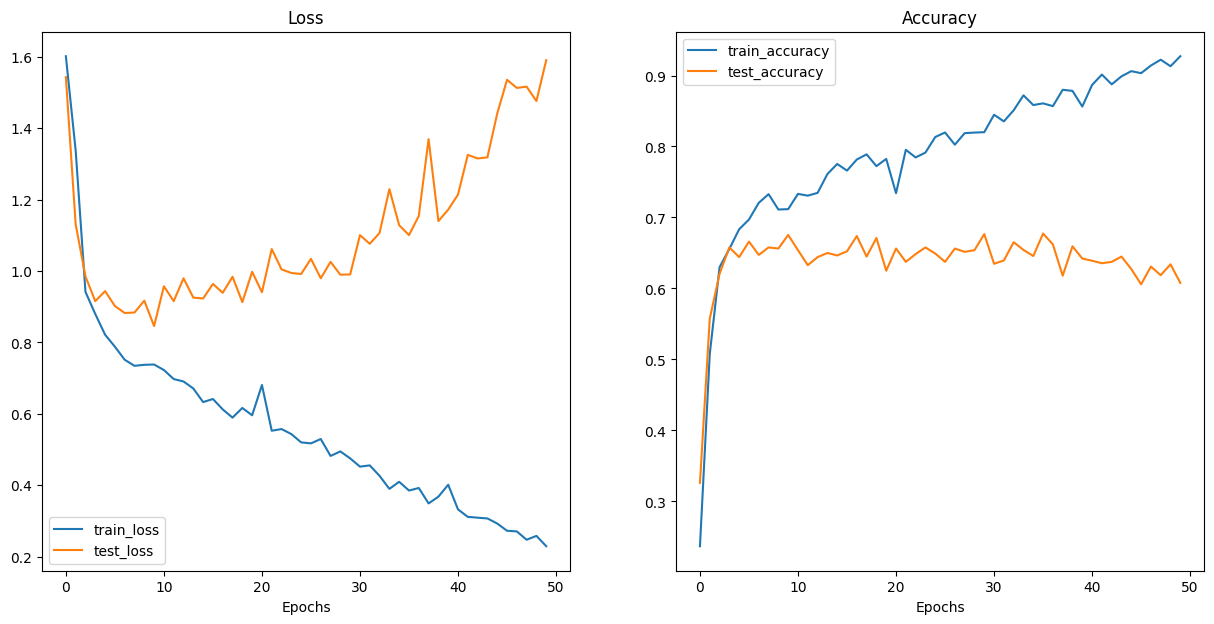

In [31]:
plot_loss_curves(model_0_results)

## This is a clear case of overfitting. Let us augment data to help the model learn patterns instead of mere memorization.

In [32]:
from torchvision.transforms import v2
train_augmented_transform = v2.Compose([
    v2.Resize(size = (64,64)),
    v2.TrivialAugmentWide(num_magnitude_bins = 31),
    v2.PILToTensor(),
    v2.ToDtype(dtype = torch.float, scale = True)

])

test_transform_simple = v2.Compose([
    v2.Resize((64,64)),
    v2.PILToTensor(),
    v2.ToDtype(dtype = torch.float, scale = True)
])

In [33]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_augmented_transform)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform_simple)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 999
     Root location: data/landscape data/train
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  TrivialAugmentWide(interpolation=InterpolationMode.NEAREST, num_magnitude_bins=31)
                  PILToTensor()
                  ToDtype(scale=True)
            ),
 Dataset ImageFolder
     Number of datapoints: 500
     Root location: data/landscape data/test
     StandardTransform
 Transform: Compose(
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=warn)
                  PILToTensor()
                  ToDtype(scale=True)
            ))

In [34]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c10cc6e8970>,
 <torch.utils.data.dataloader.DataLoader at 0x7c10cc7e6bf0>)

In [35]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=5, bias=True)
  )
)

In [36]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6102 | train_acc: 0.1968 | test_loss: 1.5775 | test_acc: 0.3008
Epoch: 2 | train_loss: 1.4825 | train_acc: 0.3538 | test_loss: 1.3247 | test_acc: 0.4332
Epoch: 3 | train_loss: 1.3957 | train_acc: 0.4192 | test_loss: 1.2629 | test_acc: 0.4730
Epoch: 4 | train_loss: 1.3263 | train_acc: 0.4520 | test_loss: 1.2142 | test_acc: 0.4551
Epoch: 5 | train_loss: 1.3581 | train_acc: 0.4322 | test_loss: 1.2042 | test_acc: 0.4879
Epoch: 6 | train_loss: 1.2971 | train_acc: 0.4778 | test_loss: 1.1744 | test_acc: 0.5219
Epoch: 7 | train_loss: 1.2936 | train_acc: 0.4894 | test_loss: 1.1360 | test_acc: 0.5703
Epoch: 8 | train_loss: 1.2801 | train_acc: 0.4821 | test_loss: 1.1091 | test_acc: 0.5938
Epoch: 9 | train_loss: 1.2050 | train_acc: 0.5409 | test_loss: 1.0650 | test_acc: 0.5605
Epoch: 10 | train_loss: 1.2062 | train_acc: 0.5286 | test_loss: 0.9902 | test_acc: 0.6312
Epoch: 11 | train_loss: 1.1934 | train_acc: 0.5432 | test_loss: 1.0318 | test_acc: 0.5766
Epoch: 12 | train_l

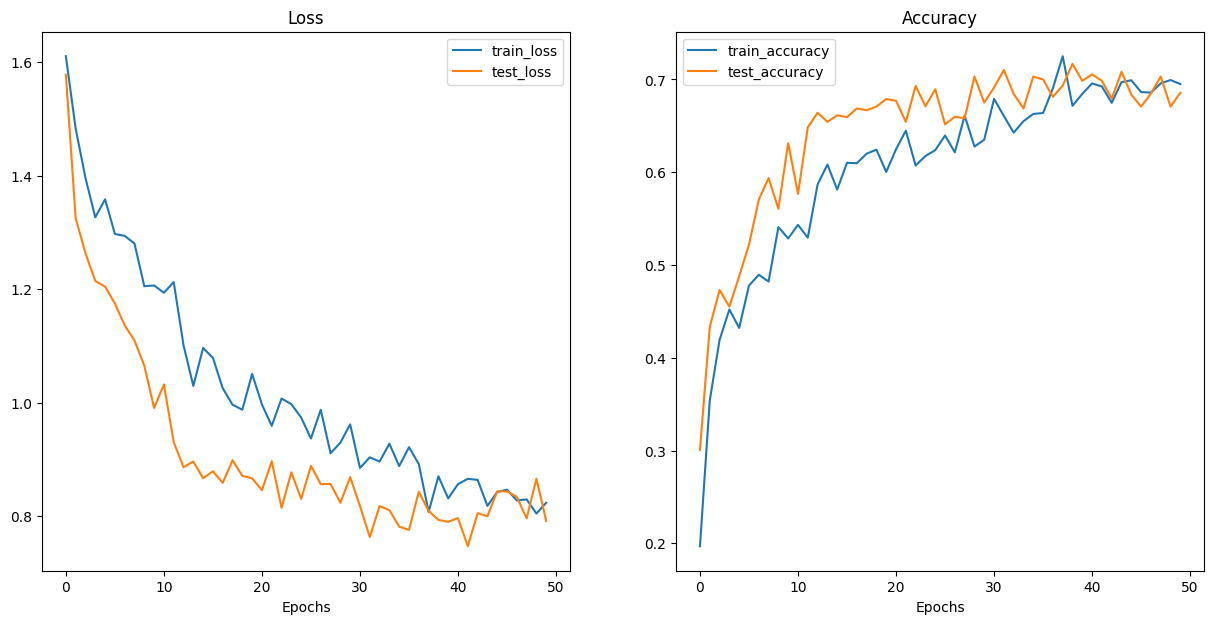

In [37]:
plot_loss_curves(model_1_results)

## Clearly, **DATA AUGMENTING** is helping the model avoid overfitting and really learn the patterns in the data.

In [38]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.602210,0.236886,1.543700,0.326172
1,1.337782,0.507673,1.131172,0.557422
2,0.941779,0.629883,0.985126,0.620703
3,0.879806,0.655692,0.915809,0.657813
4,0.821864,0.683454,0.943982,0.644141
5,0.788287,0.697126,0.902198,0.666016
6,0.751600,0.720703,0.882702,0.647266
7,0.734697,0.732840,0.883981,0.657813
8,0.737467,0.711217,0.917188,0.656250
9,0.738342,0.711775,0.846096,0.675391


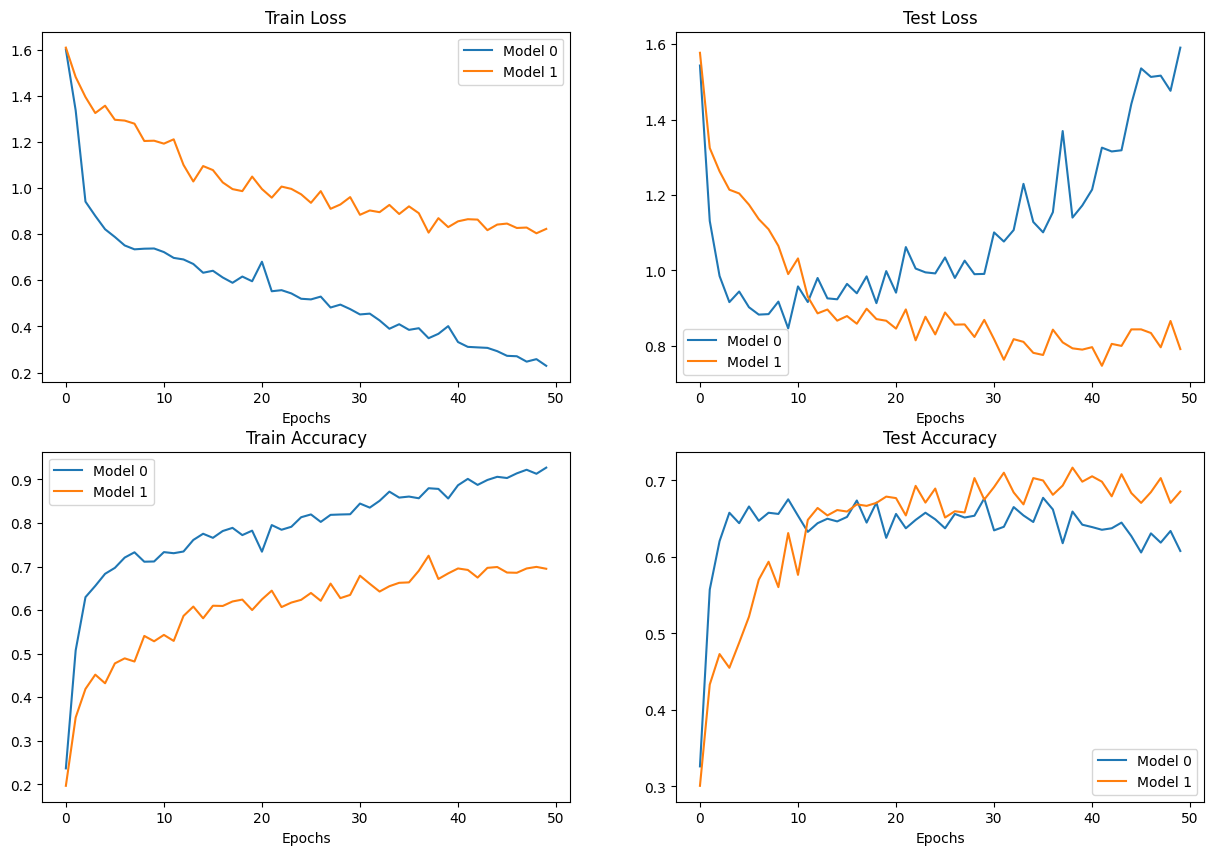

In [39]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Making predictions on a custom image

In [40]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "glacier_like_mountain.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://github.com/somewhereovertherainbo/COMPUTERVISION/blob/main/OIP.jpeg?raw=true")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [41]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 149, 147,  ..., 116, 121, 121],
         [156, 151, 152,  ..., 116, 121, 121],
         [167, 162, 164,  ..., 117, 120, 120],
         ...,
         [127, 122, 101,  ...,  77,  91,  94],
         [131, 138, 137,  ...,  39, 102, 105],
         [138, 143, 142,  ...,  47, 100, 103]],

        [[172, 167, 165,  ..., 122, 127, 127],
         [172, 167, 168,  ..., 122, 127, 127],
         [182, 177, 179,  ..., 123, 126, 126],
         ...,
         [153, 148, 127,  ...,  72,  86,  89],
         [157, 164, 163,  ...,  34,  97, 100],
         [164, 169, 168,  ...,  42,  95,  98]],

        [[196, 191, 189,  ..., 144, 149, 149],
         [197, 190, 193,  ..., 144, 149, 149],
         [205, 198, 202,  ..., 145, 148, 148],
         ...,
         [186, 181, 160,  ...,  79,  93,  96],
         [190, 197, 196,  ...,  41, 104, 107],
         [197, 202, 201,  ...,  49, 102, 105]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 316, 474])

Custom image dtype

In [42]:
transformed_custom_image = simple_transform(custom_image_uint8)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'torch.Size([3, 64, 64])')

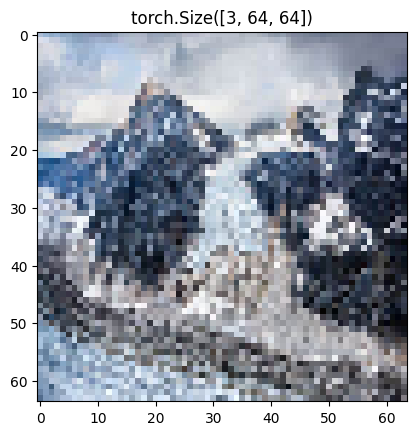

In [43]:
plt.imshow(transformed_custom_image.permute(1,2,0))
plt.title(transformed_custom_image.shape)

In [44]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = transformed_custom_image.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {transformed_custom_image.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(transformed_custom_image.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [45]:
custom_image_pred, class_names[custom_image_pred.argmax().item()]

(tensor([[-1.4126, -3.6076, -1.5866,  1.3971, -0.4142]]), 'Glacier')

 WAO! That is pretty good!

 Let us functionize this all

In [46]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path))

    # 3. Transform if necessary
    if transform:
        target_image_transformed = transform(target_image)
        # print(target_image_transformed.shape)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image_transformed.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image_transformed.permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

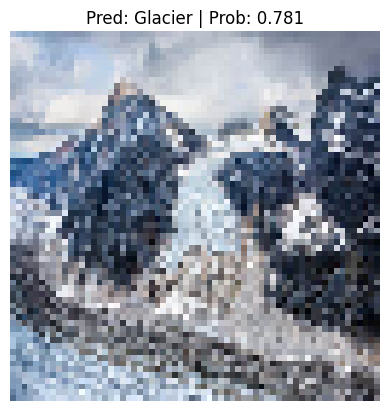

In [47]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=simple_transform,
                    device=device)